# PS reconstruction slice emittance example

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

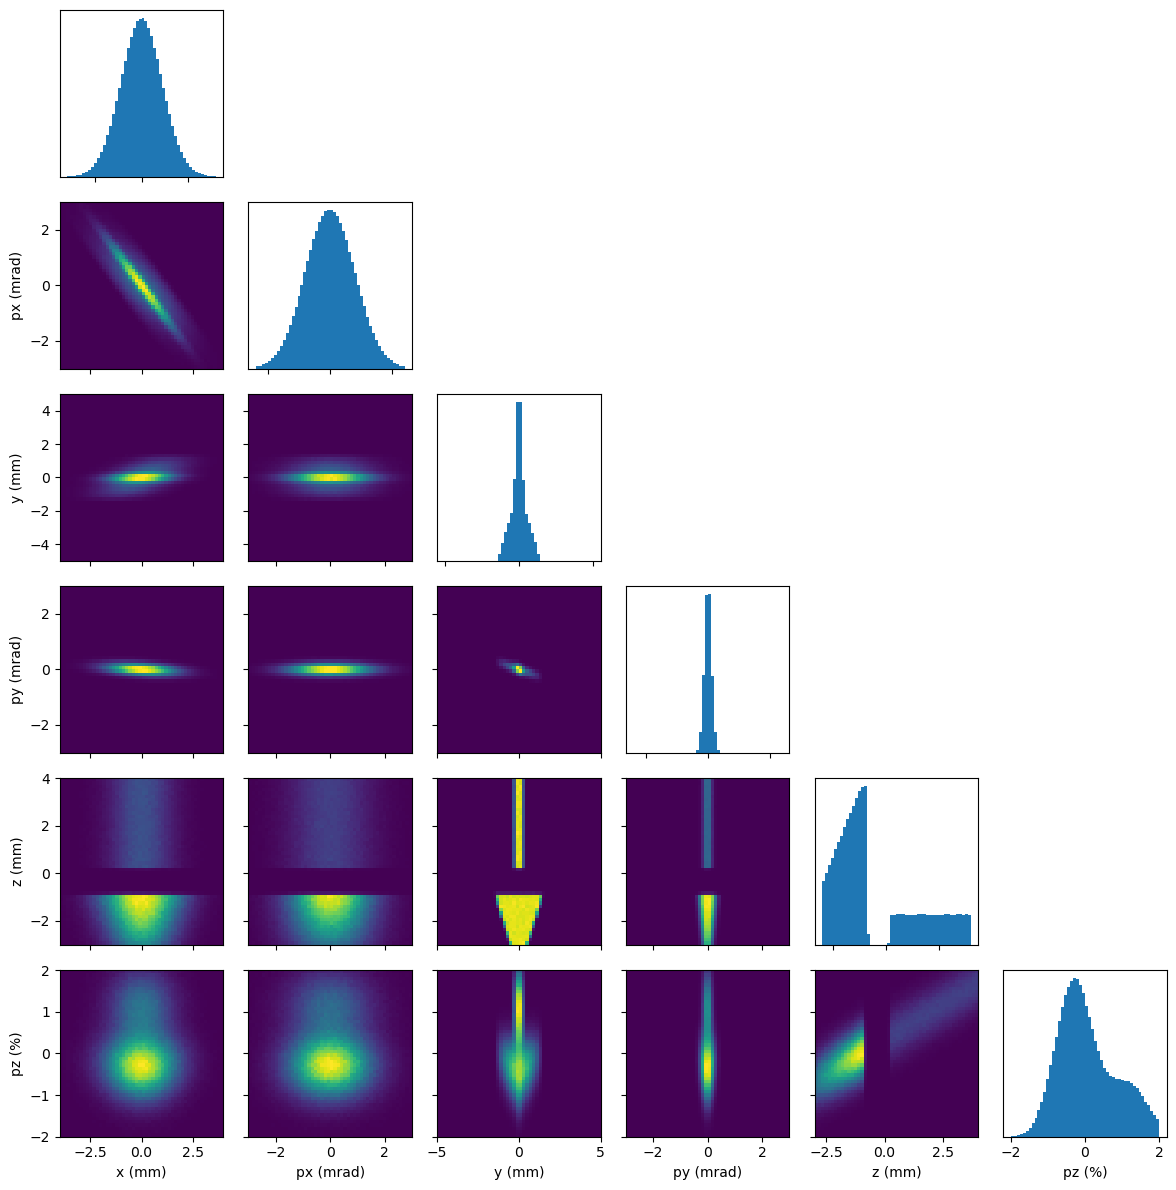

In [2]:
#plot gt beam
p0c = 10.0e6
save_dir = os.path.join('data','eex_beam')
gt_beam = create_beam(
    base_yaml = os.path.join(save_dir,'base.yaml'),
    transforms_yaml = os.path.join(save_dir,'transforms.yaml'),
    p0c = p0c,
#    save_as = os.path.join('gt_beam.pt'),
    n_particle=1_000_000
)

lims = np.array([[-4e-3, 4e-3],
                 [-3e-3, 3e-3],
                 [-5e-3, 5e-3],
                 [-3e-3, 3e-3],
                 [-3e-3, 4e-3],
                 [-2e-2, 2e-2]])

# swap x-z distributions
data = gt_beam.data.clone()
data = torch.index_select(data, -1, torch.tensor([4,1,2,3,0,5]))
data[:,1] = data[:,1] * 0.5 - data[:,0]
data[:,-1] = data[:,-1] * 2.0
data[:,-2] = data[:,-2] * 3.0 - 1e-3
data[:,0] = data[:,0] + data[:,2]

gt_beam.data = data

fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims=lims,
)



plt.show()

## Define diagnostics lattice parameters

In [3]:
# triplet params obtained from triplet-opt.ipynb
#k1 =    13.733624
#k2 =  -23.473085
#k3 =   24.013177

k1 =    7.117084
k2 =  -21.630823
k3 =   26.233582

In [4]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
#lattice.elements[0].K1.data = torch.tensor(k1)
#lattice.elements[2].K1.data = torch.tensor(k2)
#lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 7
ks = torch.linspace(-40, 40, n_ks) # quad ks
vs = torch.tensor([0, 1.0e6])#5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-25, 25, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 7, 2, 2])
torch.Size([3, 7, 2, 2, 1])


## Complete 3D scan training data

In [5]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
#    save_as = '3d_scan_train.dset'
)

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

torch.Size([28, 3, 1])
torch.Size([28, 1, 200, 200])


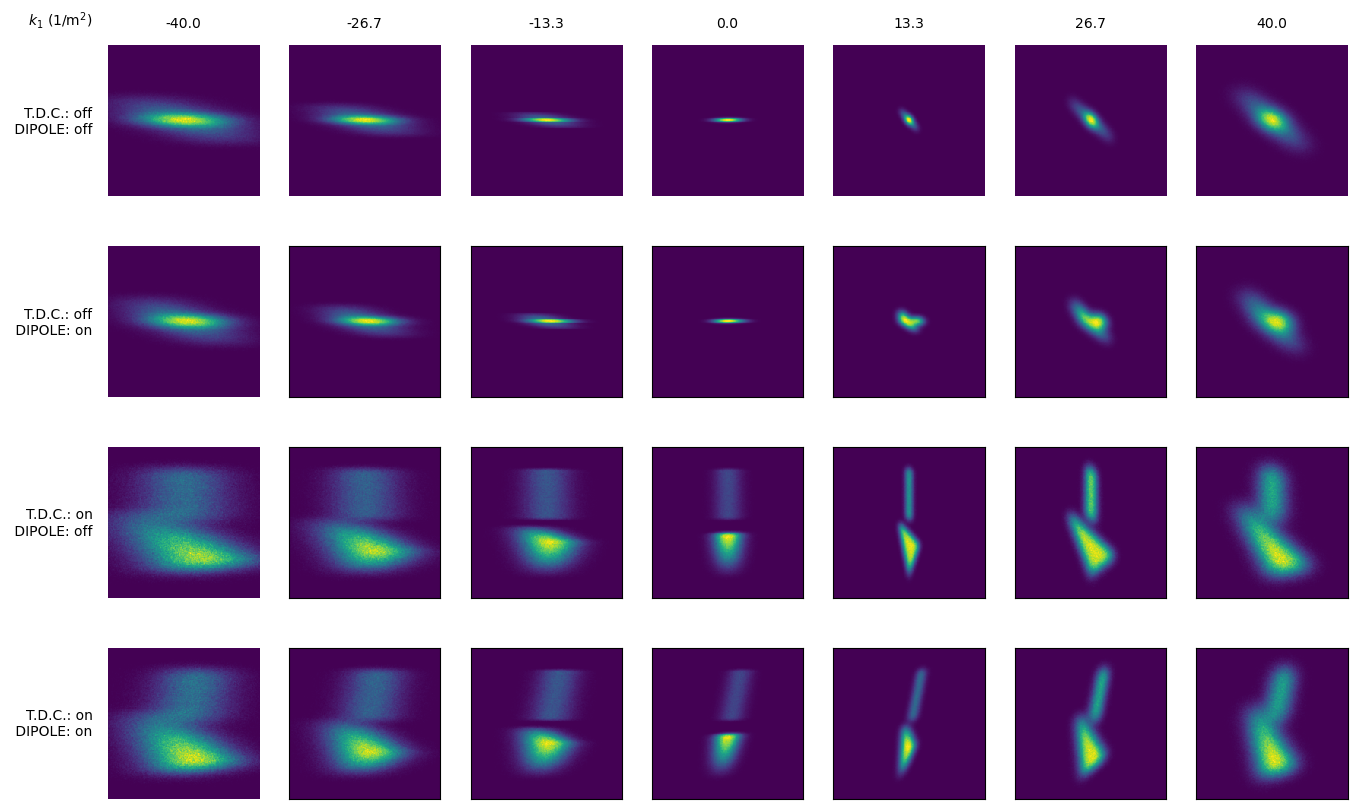

In [6]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

In [7]:
fig.savefig("eex_data.png",dpi=300)

### 10,000 particles, multi-GPU

In [7]:
%%time
import torch

pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan,
    lattice,
    p0c,
    screen,
    ids = scan_ids,
    n_epochs = 5_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    lambda_=1e14,
    save_dir = save_dir,
    distribution_dump_frequency=200,
    distribution_dump_n_particles=1_000_000,
    use_decay=False
)

Using device: cuda:0


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(3.4564e+09, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(6.2745e+08, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(7.3868e+08, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(6.2707e+08, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(3.7519e+08, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(3.8810e+08, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(4.9811e+08, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(4.3267e+08, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(4.7777e+08, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(4.5166e+08, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(3.6158e+08, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(3.5029e+08, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(4.6923e+08, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(4.1261e+08, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(4.1233e+08, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(3.9323e+08, device='cuda:

KeyboardInterrupt: 

In [8]:
torch.cuda.empty_cache()

-4.0 4.0
-3.0 3.0
-1.5 1.5
-2.0 2.0
-5.0 5.0
-2.0 2.0


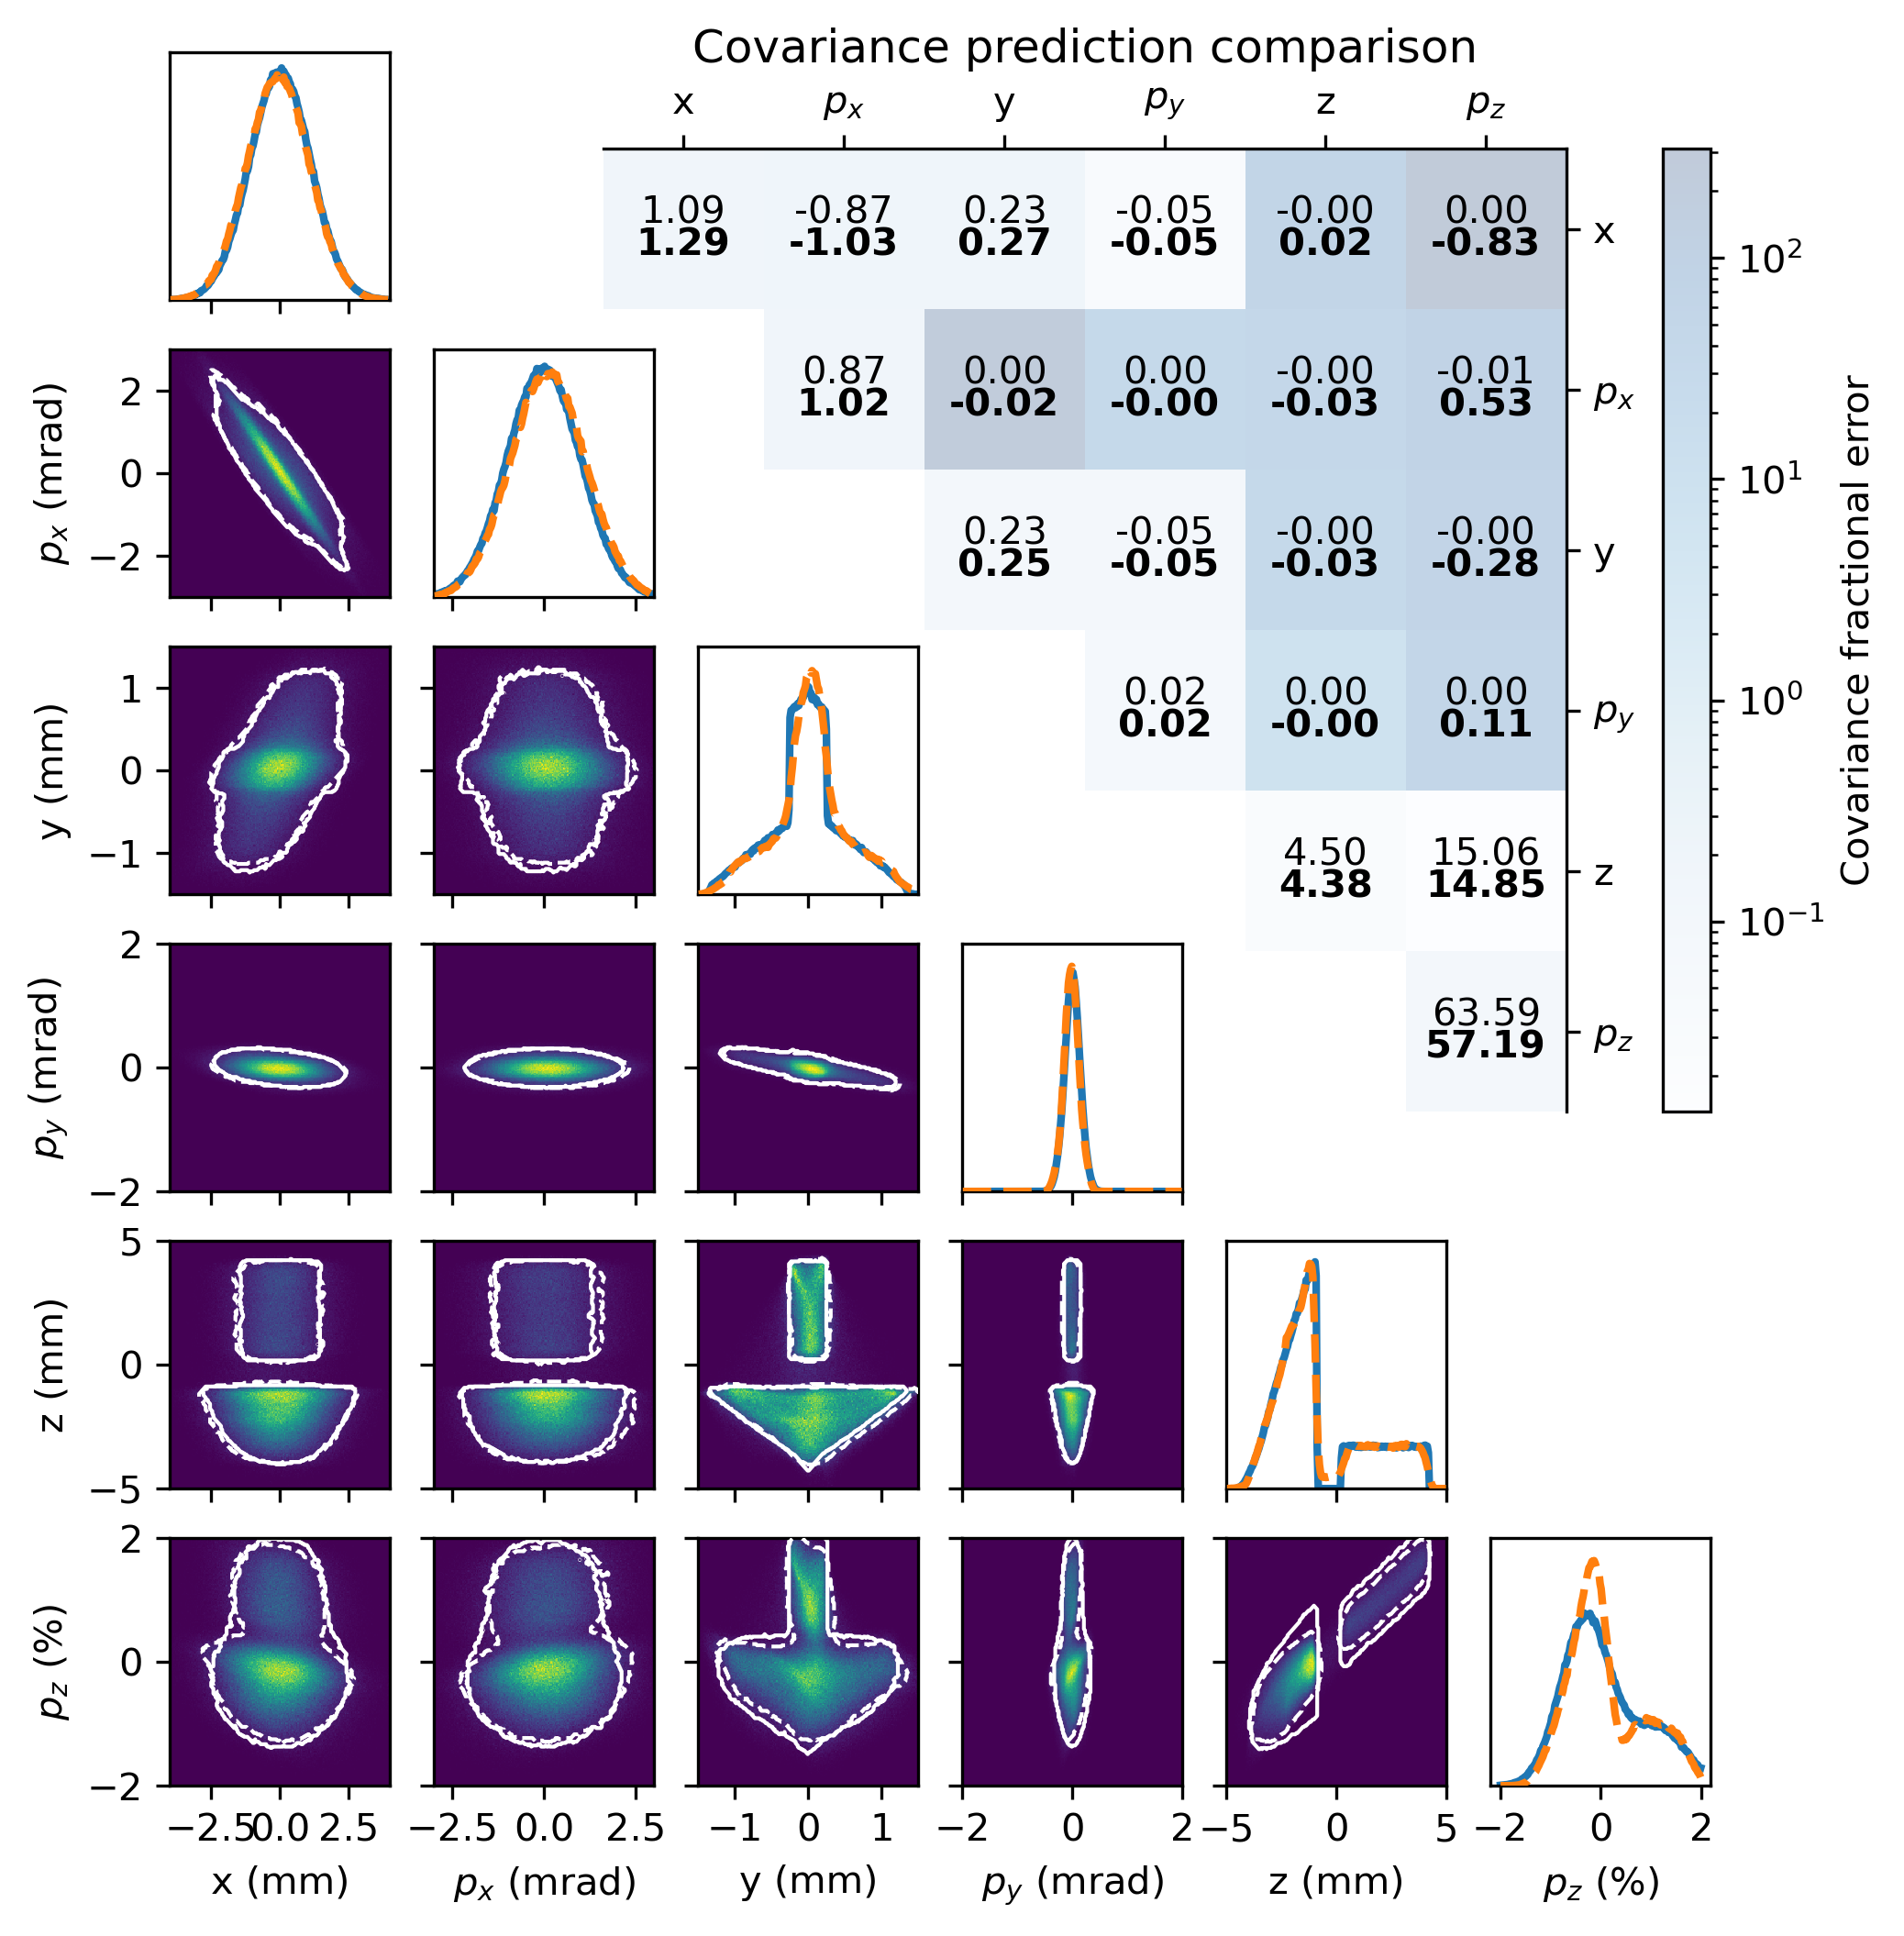

In [9]:
import torch
from stats import plot_prab_figure
import os
recn_dist = torch.load(os.path.join(save_dir, 'dist_3200.pt'))

slims = np.array([[-4, 4],
                 [-3, 3],
                 [-1.5, 1.5],
                 [-2, 2],
                 [-5, 5],
                 [-2, 2]])

fig = plot_prab_figure(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [90],
    custom_lims=slims,
    contour_smoothing=0.0,
)

In [10]:
fig.savefig("eex_reconstruction.png", dpi=300)

In [10]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

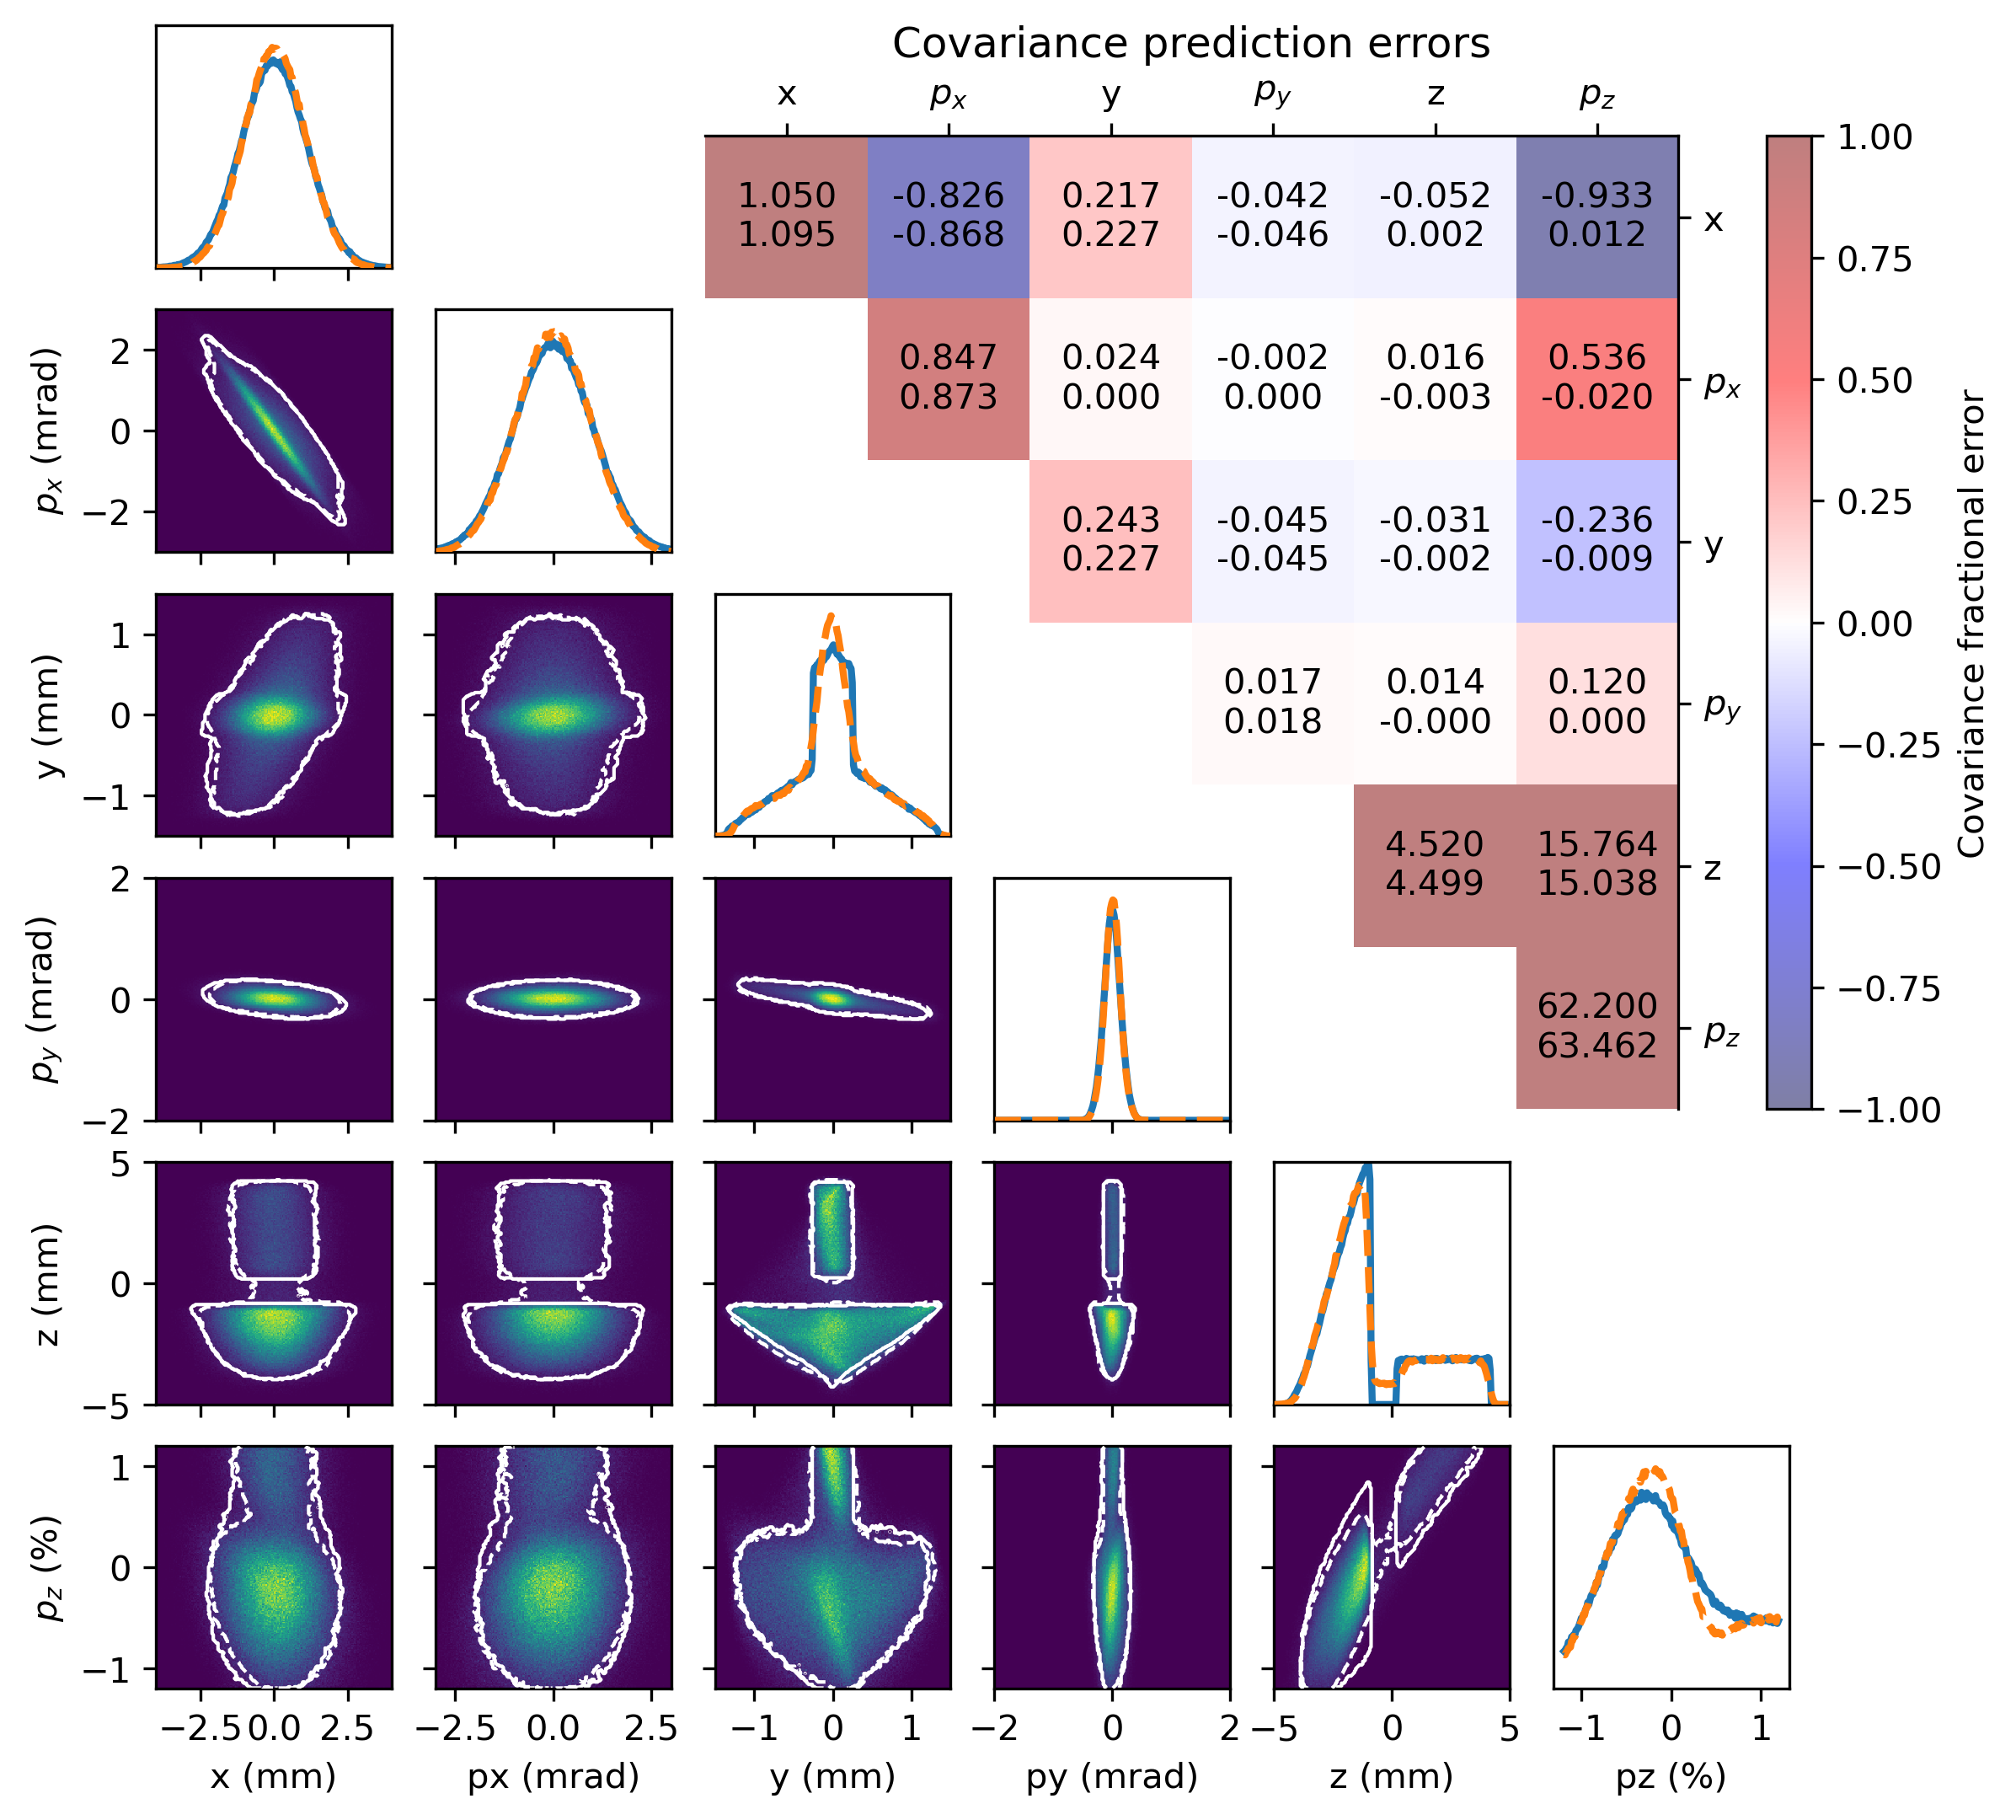

In [11]:
#frac_error = (cov_gt_frac - cov_reconstruction_frac)/cov_gt_frac
frac_error = cov_reconstruction_frac*1e6

mask = np.tri(frac_error.shape[0],k=-1)
frac_error = np.flipud(np.ma.array(frac_error, mask=mask))

manipulated_cov_gt = np.flipud(cov_gt_frac).T

def plot_cov_sigmas(cov_sigmas, fig=None):
    coords = ('x', '$p_x$', 'y', '$p_y$', 'z', '$p_z$')
    
    if fig is None:
        fig, ax = plt.subplots()
    else:
        center = 0.375
        cax_width = 0.025
        buffer = 0.05
        ax_width = 1-center-cax_width - buffer
        ax = fig.add_axes([center, center, ax_width, ax_width],zorder=0)
        cax = fig.add_axes([center + ax_width + buffer, center, cax_width, ax_width],zorder=0)
        
    c = ax.pcolormesh(cov_sigmas, cmap='seismic', vmin=-1, vmax=1, alpha=0.5)
    for (j,i), label in np.ndenumerate(cov_sigmas):
        if not cov_sigmas.mask[i,j]:
            ax.text(i + 0.5, j + 0.5, f'{label:.3f}\n{manipulated_cov_gt[i,j]*1e6:.3f}', ha='center', va='center')
    fig.colorbar(c,cax=cax,label="Covariance fractional error")
    ax.set_xticks(np.arange(len(coords))+0.5, labels=coords)
    ax.set_yticks(np.arange(len(coords))+0.5, labels=coords[::-1])
    
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #fig.tight_layout()
    
    ax.set_title("Covariance prediction errors")

    return fig, ax

fig, ax = plot_cov_sigmas(frac_error,fig)
a = fig.get_axes()[:-10]
for ele in a:
    ele.zorder=10

fig.set_size_inches(7,7)
fig